In [952]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import os
import sqlite3
%matplotlib inline
import plotly.express as px
from plotly import graph_objs as go
import plotly.figure_factory as ff

# Model
# Compare the Logistic Regression Model V.S. Base Rate Model V.S. Random Forest Model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

import toolkit as tool

import os

os.system('date')

dom 10 dez 2023 19:36:51 -03


0

### Objective

The data is for company X which is trying to control attrition. There are two sets of data: “Existing employees” and “Employees who have left”. Following attributes are available for every employee.
 - Satisfaction Level
 - Last evaluation
 - Number of projects
 - Average monthly hours
 - Time spent at the company
 - Whether they have had a work accident
 - Whether they have had a promotion in the last 5 years
 - Departments (column sales)
 - Salary
 - Whether the employee has left

In [953]:
# loading dataset.
df = pd.read_csv('../datasets/HR_COM1_tomodel.csv')
df.head(100)

,Emp ID,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,dept,salary
0,1,0.38,0.53,2,157,3,0,1,0,7,1
1,2,0.80,0.86,5,262,6,0,1,0,7,2
2,3,0.11,0.88,7,272,4,0,1,0,7,2
3,4,0.72,0.87,5,223,5,0,1,0,7,1
4,5,0.37,0.52,2,159,3,0,1,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.37,0.51,2,155,3,0,1,0,7,1
96,97,0.10,0.77,6,265,4,0,1,0,7,1
97,98,0.10,0.84,6,279,4,0,1,0,7,1
98,99,0.11,0.97,6,284,4,0,1,0,7,1


In [954]:
print(df['dept'].value_counts(normalize=True).map('{:.2%}'.format))

7    27.60%
9    18.13%
8    14.86%
0     8.18%
6     6.01%
5     5.72%
1     5.25%
2     5.11%
3     4.93%
4     4.20%
Name: dept, dtype: object


In [955]:
df.promotion.min()

0

In [956]:
shape_rows = df.shape[0]
shape_columns = df.shape[1]

print(f'Dataset rows = {shape_rows} and columns = {shape_columns}.')

Dataset rows = 14999 and columns = 11.


### X and y 

In [957]:
# Set the input X to the K-Means.
X = df.drop(columns=['turnover', 'Emp ID'])
y = df['turnover']

In [958]:
# Method of inertia to find the ideal of clusters.
inertia = []
for k in range(1, 11):
    clf = KMeans(n_clusters = k , random_state= 123)
    clf.fit(X)
    inertia.append(clf.inertia_)

In [959]:
pd.DataFrame({"k":list(range(1 , 11)),
              "inércia": inertia})

,k,inércia
0,1,3.759731e+07
1,2,8.982092e+06
2,3,4.520220e+06
3,4,2.909351e+06
4,5,2.096935e+06
5,6,1.567737e+06
6,7,1.256145e+06
7,8,9.821504e+05
8,9,7.868616e+05
9,10,6.740358e+05


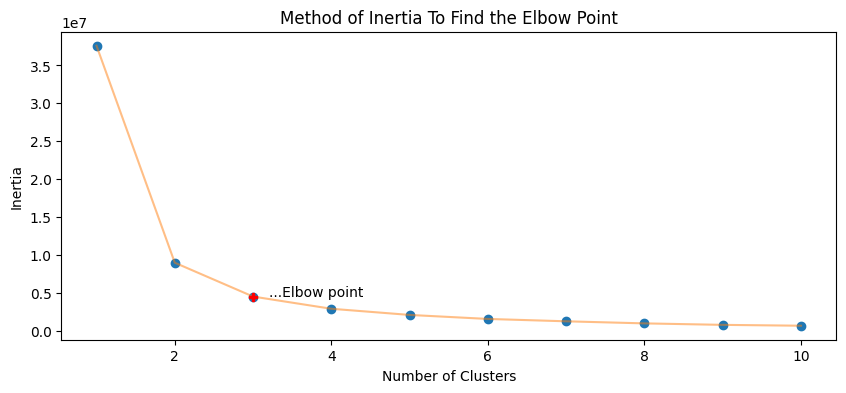

In [960]:
plt.figure(1 , figsize = (10 ,4))
plt.title('Method of Inertia To Find the Elbow Point')
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')

# adicionado depois... ;-)
plt.plot(3 , inertia[2] , 'P', alpha = 1, color = 'red')
plt.text(3 + 0.2 , inertia[2] , '...Elbow point')

plt.show()

In [961]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Employee Turnover
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df[df.turnover==1][["satisfaction","evaluation"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

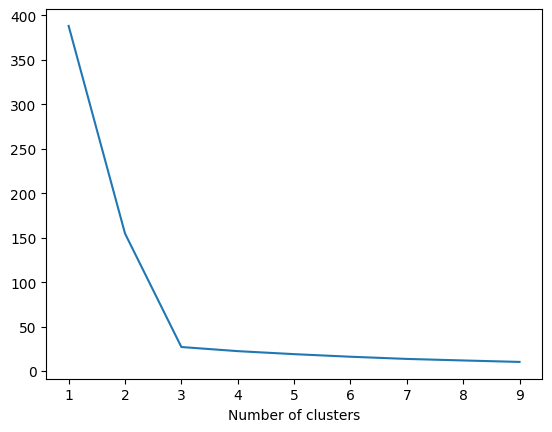

In [962]:
# Determine number of clusters with K-means elbow method
# The arc of the elbow shows that number 3 is our best fit and as thus we would create  3 clusters of employee
sse={}
br = df[df.turnover==1][["satisfaction","evaluation"]]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df[df.turnover==1][["satisfaction","evaluation"]])

    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [963]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter(
    x=df["satisfaction"], y=df["evaluation"],
    mode='markers',
    marker=dict(
        color= kmeans_colors,
        opacity=[1, 0.8, 0.6, 0.4],
        size=[40, 60, 80, 100],
    )
)])
fig.update_layout(title_text='Employee Cluster Chart')
fig.show()

### Train and Test features

In [964]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123, stratify=y)

### Modeling

In [965]:
modelname = 'modelname'

def metric_models(modelname, y_test, y_pred):
    acc   = round(accuracy_score(y_test,y_pred), 3)*100
    score = round(metrics.precision_score(y_test, y_pred, average='macro')*100, 2)
    mae   = round(mean_absolute_error(y_test, y_pred), 5)


    print(f'{modelname} model:')
    print(f"accuracy........:{acc}%")
    print(f'score...........:{score}')
    print(f"Mean Absolute Error: {mae}")

In [966]:
def plot_conf_matrix(y_test, y_pred):
    confusion_matrix1 = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix1).plot()
    plt.grid(False)
    plt.show()

#### Logistic Regression V.S. Random Forest V.S. Decision Tree V.S. AdaBoost Model


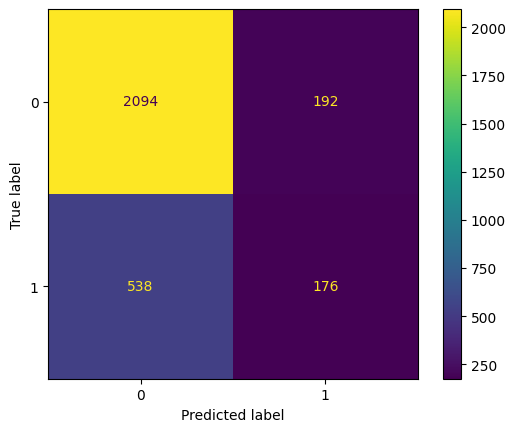

In [967]:
logreg_model = LogisticRegression(penalty='l2', C=1)

logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)

plot_conf_matrix(y_test, y_pred_logreg)

In [968]:
metric_models('LogisticRegression', y_test, y_pred_logreg)

LogisticRegression model:
accuracy........:75.7%
score...........:63.69
Mean Absolute Error: 0.24333


In [969]:
# Using 10 fold Cross-Validation to train our Logistic Regression Model
kfold = model_selection.KFold(n_splits=10)
modelCV = LogisticRegression(class_weight = "balanced")
scoring = 'roc_auc'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.816 (0.015)


In [970]:
# NOTE: By adding in "class_weight = balanced", the Logistic Auc increased by about 10%! This adjusts the threshold value
logis = LogisticRegression(class_weight = "balanced")
logis.fit(X_train, y_train)
print ("\n\n ---Logistic Model---")
logit_roc_auc = roc_auc_score(y_test, logis.predict(X_test))
print ("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(y_test, logis.predict(X_test)))



 ---Logistic Model---
Logistic AUC = 0.75
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      2286
           1       0.48      0.77      0.59       714

    accuracy                           0.75      3000
   macro avg       0.70      0.75      0.70      3000
weighted avg       0.81      0.75      0.76      3000



In [971]:
lgb_model = lgb.LGBMClassifier()

# Train the model
lgb_model.fit(X_train, y_train)

# predict the results
y_pred_lgb=lgb_model.predict(X_test)

print ("\n\n ---LGBMClassifier Model---")
lgb_roc_auc = roc_auc_score(y_test, y_pred_lgb)
print ("LGBMClassifier AUC = %2.2f" % lgb_roc_auc)
print(classification_report(y_test, y_pred_lgb))



 ---LGBMClassifier Model---
LGBMClassifier AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.96      0.97       714

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



In [972]:
metric_models('LightGBMClassifier', y_test, y_pred_lgb)

LightGBMClassifier model:
accuracy........:98.6%
score...........:98.34
Mean Absolute Error: 0.014


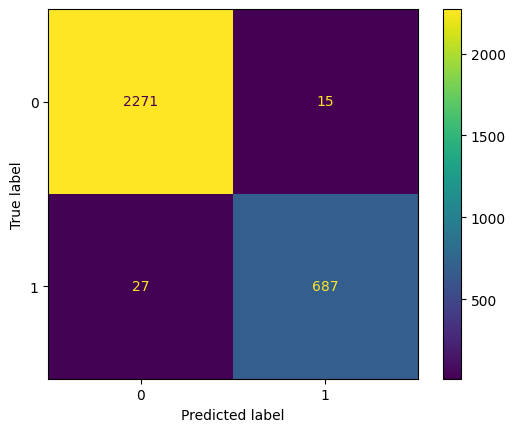

In [973]:
plot_conf_matrix(y_test, y_pred_lgb)

In [974]:
# Decision Tree Model
dtree_model = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree_model.fit(X_train,y_train)
y_pred_dtree = dtree_model.predict(X_test)

print ("\n\n ---Decision Tree Model---")
dt_roc_auc = roc_auc_score(y_test, y_pred_dtree)
print ("Decision Tree AUC = %2.2f" % dt_roc_auc)
print(classification_report(y_test, y_pred_dtree))



 ---Decision Tree Model---
Decision Tree AUC = 0.95
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2286
           1       0.92      0.92      0.92       714

    accuracy                           0.96      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.96      0.96      0.96      3000



In [975]:
metric_models('Decision Tree', y_test, y_pred_dtree)

Decision Tree model:
accuracy........:96.2%
score...........:94.88
Mean Absolute Error: 0.038


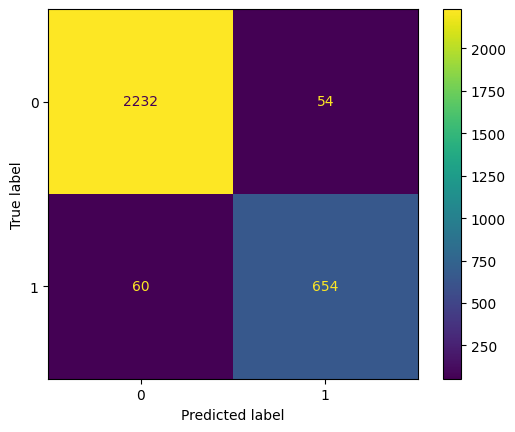

In [976]:
plot_conf_matrix(y_test, y_pred_dtree)

In [977]:
# Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=10000, 
    max_depth=None, 
    min_samples_split=10, 
    class_weight="balanced",
    n_jobs=-1
    #min_weight_fraction_leaf=0.02 
    )
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, y_pred_rf))



 ---Random Forest Model---
Random Forest AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.99      0.96      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



In [978]:
metric_models('Random Forest', y_test, y_pred_rf)

Random Forest model:
accuracy........:98.9%
score...........:98.96
Mean Absolute Error: 0.01133


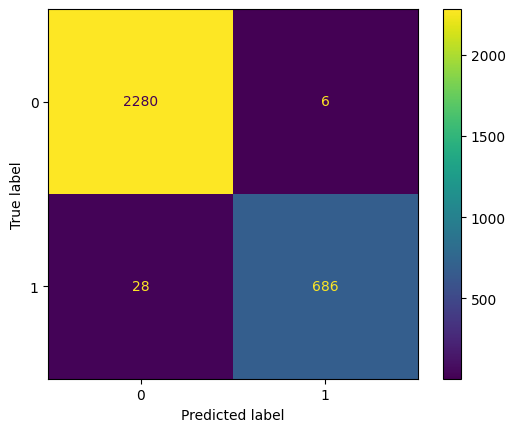

In [979]:
plot_conf_matrix(y_test, y_pred_rf)

In [980]:
list_name_features = []
index = 1

for feat, importance in zip(X.columns, rf.feature_importances_):
    importance = round(importance*100, 2)
    print(f'{index} - feature: {feat}, importance: {importance} %')
    list_name_features.append(feat)
    index += 1

1 - feature: satisfaction, importance: 29.7 %
2 - feature: evaluation, importance: 12.56 %
3 - feature: projectCount, importance: 15.26 %
4 - feature: averageMonthlyHours, importance: 14.69 %
5 - feature: yearsAtCompany, importance: 25.24 %
6 - feature: workAccident, importance: 0.7 %
7 - feature: promotion, importance: 0.11 %
8 - feature: dept, importance: 1.11 %
9 - feature: salary, importance: 0.63 %


In [981]:
list_feat_importances = list(rf.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 29.7 %
evaluation.......: 12.56 %
projectCount.......: 15.26 %
averageMonthlyHours.......: 14.69 %
yearsAtCompany.......: 25.24 %
workAccident.......: 0.7 %
promotion.......: 0.11 %
dept.......: 1.11 %
salary.......: 0.63 %


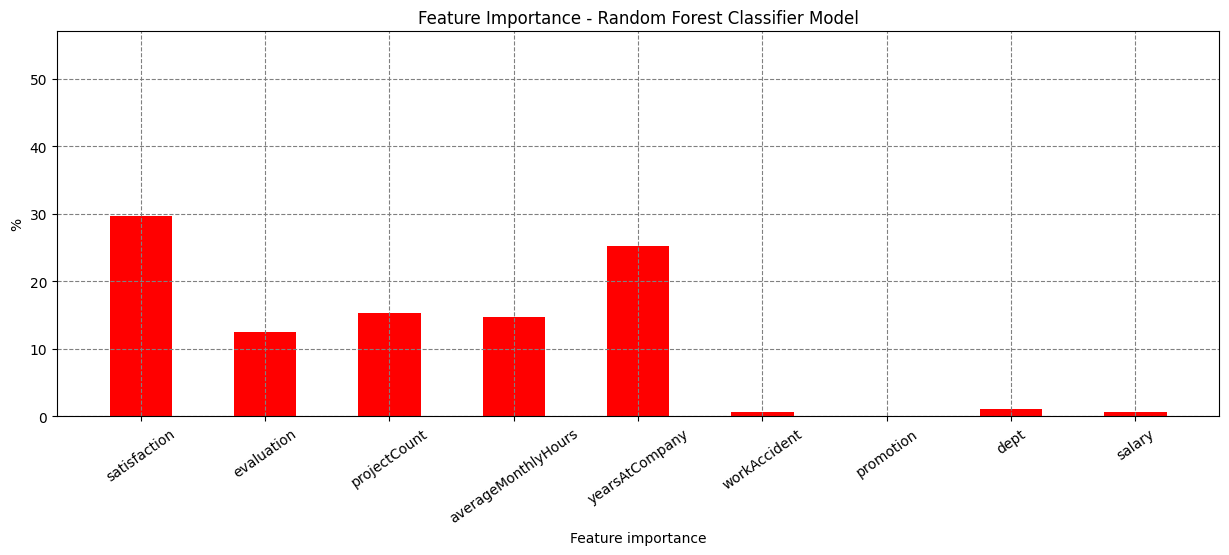

In [982]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,57)
plt.title("Feature Importance - Random Forest Classifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [983]:
# Ada Boost
ada_model = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
ada_model.fit(X_train,y_train)
y_pred_ada = ada_model.predict(X_test)
print ("\n\n ---AdaBoost Model---")
ada_roc_auc = roc_auc_score(y_test, y_pred_ada)
print ("AdaBoost AUC = %2.2f" % ada_roc_auc)
print(classification_report(y_test, y_pred_ada))



 ---AdaBoost Model---
AdaBoost AUC = 0.93
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2286
           1       0.91      0.89      0.90       714

    accuracy                           0.95      3000
   macro avg       0.94      0.93      0.93      3000
weighted avg       0.95      0.95      0.95      3000



In [984]:
metric_models('AdaBoost', y_test, y_pred_ada)

AdaBoost model:
accuracy........:95.19999999999999%
score...........:93.82
Mean Absolute Error: 0.04767


In [985]:
list_feat_importances = list(ada.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 31.25 %
evaluation.......: 15.0 %
projectCount.......: 11.5 %
averageMonthlyHours.......: 17.0 %
yearsAtCompany.......: 13.25 %
workAccident.......: 4.0 %
promotion.......: 0.0 %
dept.......: 2.0 %
salary.......: 6.0 %


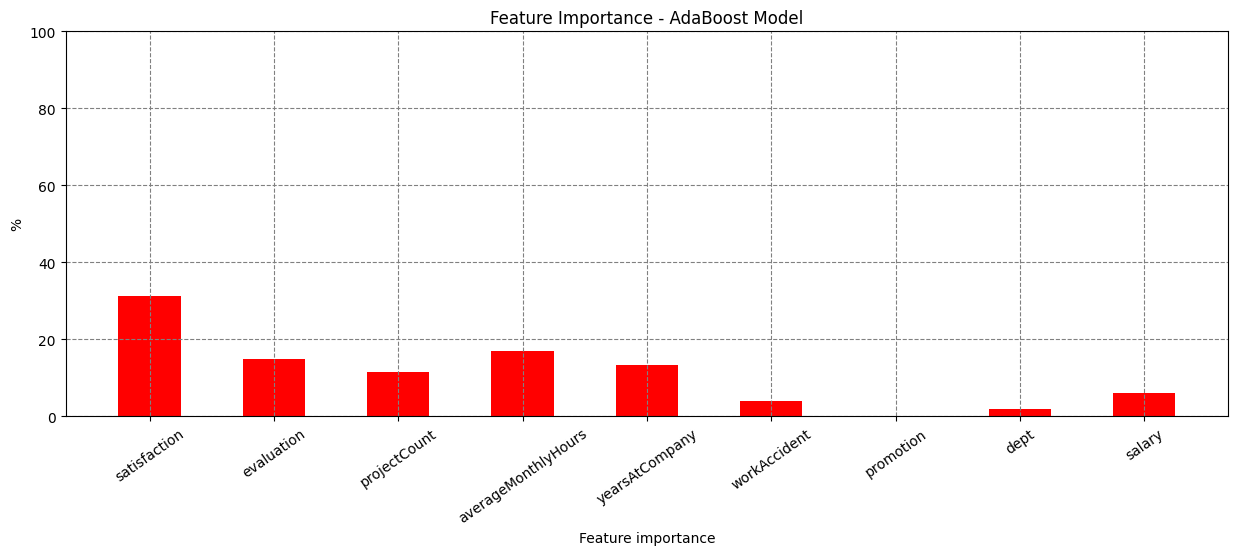

In [986]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - AdaBoost Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [987]:
# Create XGBoost model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print ("\n\n ---XGBClassifier Model---")
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)
print ("XGBClassifier AUC = %2.2f" % xgb_roc_auc)
print(classification_report(y_test, y_pred_xgb))



 ---XGBClassifier Model---
XGBClassifier AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.97      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



In [988]:
metric_models('XGBClassifier', y_test, y_pred_xgb)

XGBClassifier model:
accuracy........:98.9%
score...........:98.53
Mean Absolute Error: 0.01133


In [989]:
list_feat_importances = list(xgb_model.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 31.07 %
evaluation.......: 10.29 %
projectCount.......: 16.48 %
averageMonthlyHours.......: 5.19 %
yearsAtCompany.......: 24.55 %
workAccident.......: 6.2 %
promotion.......: 1.68 %
dept.......: 1.83 %
salary.......: 2.71 %


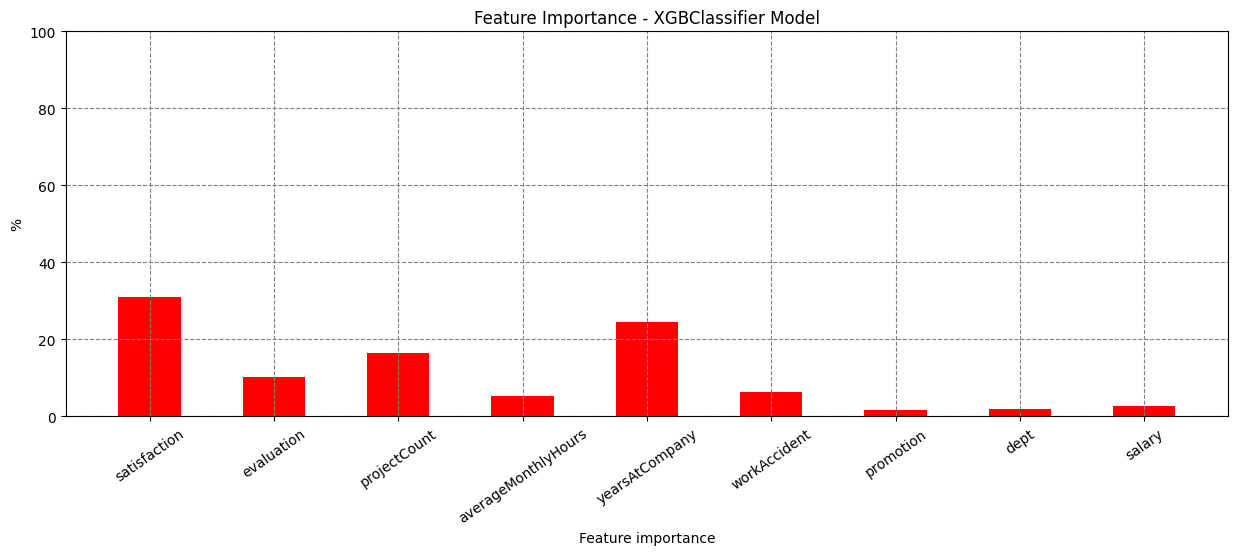

In [990]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - XGBClassifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [991]:
# Create CatBoost classifier
#cat_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', eval_metric='Accuracy')

from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier(
    iterations = 1000, # 1000 are ideal
    loss_function='MultiClass',
    bootstrap_type = "Bayesian",
    eval_metric = 'MultiClass',
    leaf_estimation_iterations = 100,
    random_strength = 0.5,
    depth = 7,
    l2_leaf_reg = 5,
    learning_rate=0.1,
    bagging_temperature = 0.5,
    thread_count=-1 # number of threads, setted all CPU cores
    #task_type = "GPU",
)

# Train the model
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
y_pred_cat = cat_model.predict(X_test)

print ("\n\n ---CatBoostClassifier Model---")
cat_roc_auc = roc_auc_score(y_test, y_pred_cat)
print ("CatBoost AUC = %2.2f" % cat_roc_auc)
print(classification_report(y_test, y_pred_cat))



 ---CatBoostClassifier Model---
CatBoost AUC = 0.99
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [992]:
metric_models('CatBoostClassifier', y_test, y_pred_cat)

CatBoostClassifier model:
accuracy........:99.1%
score...........:98.85
Mean Absolute Error: 0.00867


In [993]:
list_feat_importances = list(cat_model.feature_importances_)
dict_feat_importances = {}

i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i] # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 23.72 %
evaluation.......: 14.81 %
projectCount.......: 11.78 %
averageMonthlyHours.......: 16.01 %
yearsAtCompany.......: 17.65 %
workAccident.......: 3.29 %
promotion.......: 0.19 %
dept.......: 7.54 %
salary.......: 5.01 %


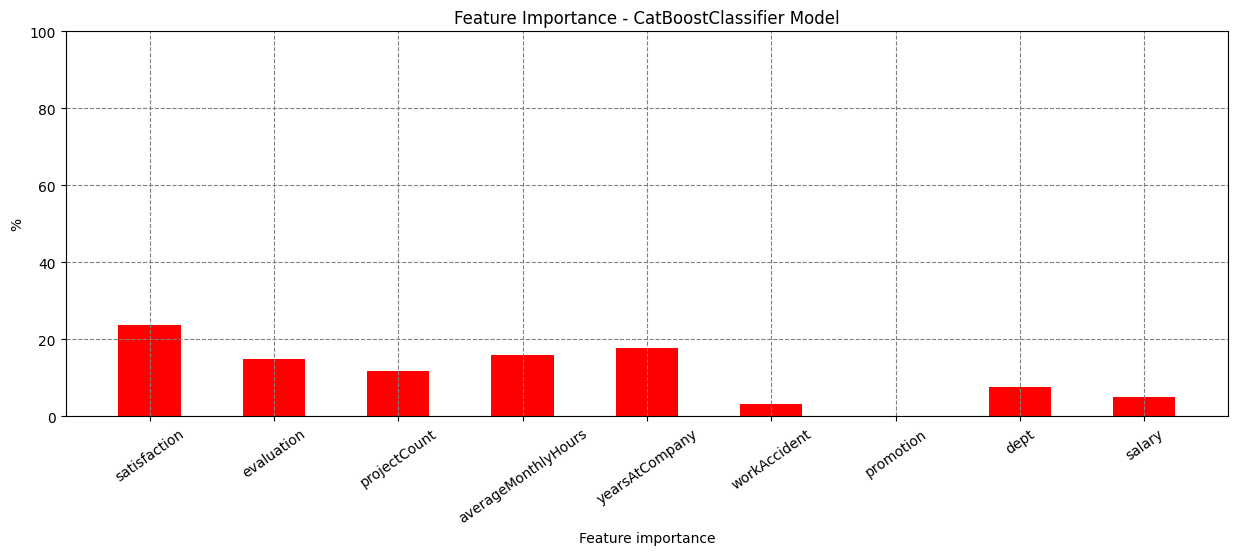

In [994]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - CatBoostClassifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

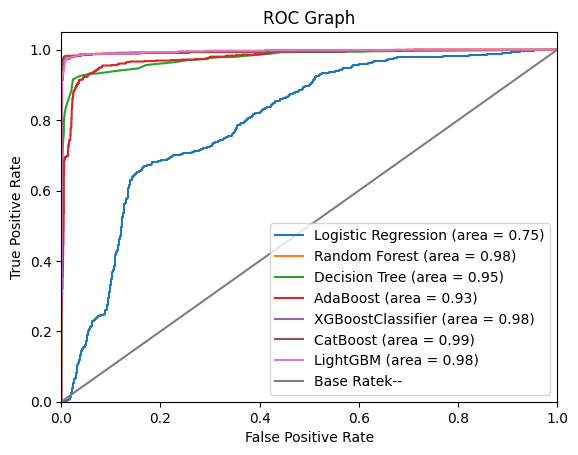

In [995]:
# Create ROC Graph
fpr, tpr, thresholds = roc_curve(y_test, logreg_model.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dtree_model.predict_proba(X_test)[:,1])
ada_fpr, ada_tpr, ada_thresholds = roc_curve(y_test, ada_model.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
cat_fpr, cat_tpr, cat_thresholds = roc_curve(y_test, cat_model.predict_proba(X_test)[:,1])
lgb_fpr, lgb_tpr, lgb_thresholds = roc_curve(y_test, lgb_model.predict_proba(X_test)[:,1])

plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# Plot Decision Tree ROC
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)

# Plot AdaBoost ROC
plt.plot(ada_fpr, ada_tpr, label='AdaBoost (area = %0.2f)' % ada_roc_auc)

# Plot XGBoostClassifier ROC
plt.plot(xgb_fpr, xgb_tpr, label='XGBoostClassifier (area = %0.2f)' % xgb_roc_auc)

# Plot XGBoostClassifier ROC
plt.plot(cat_fpr, cat_tpr, label='CatBoost (area = %0.2f)' % cat_roc_auc)

# Plot LightGBM ROC
plt.plot(lgb_fpr, lgb_tpr, label='LightGBM (area = %0.2f)' % lgb_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")

# Save the plot as a PNG file
plt.savefig('../images/roc_curve_models.png')

plt.show()

In [996]:
os.system('date')

dom 10 dez 2023 19:39:27 -03


0

#### This is for Tests!!!

In [997]:
# fake data - generated
df_test = pd.read_csv('../gendata/HR_COM1_fake_totest.csv', index_col=0)
df_test

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,dept,salary
0,0.06,0.12,6,155,8,0,1,0,3,0
1,0.73,0.51,5,144,8,1,0,0,2,0
2,0.75,0.99,4,284,4,0,1,0,5,1
3,0.59,0.95,6,272,9,0,1,1,6,1
4,0.29,0.17,7,113,3,0,0,1,6,1
...,...,...,...,...,...,...,...,...,...,...
99995,0.48,0.67,7,175,7,0,1,0,6,2
99996,0.76,0.25,4,234,6,0,1,0,3,1
99997,0.48,0.97,7,191,9,0,0,0,0,1
99998,0.14,0.65,7,262,4,1,0,1,2,1


In [998]:
df_test.shape

(100000, 10)

In [999]:
# Set the input X to the K-Means.
X = df_test.drop(columns=['turnover'])
y = df_test['turnover']

In [1000]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.8, random_state=123, stratify=y, shuffle=True)

In [1001]:
y_pred_xgb = xgb_model.predict(X_test)

In [1002]:

metric_models('XGBClassifier Test', y_test, y_pred_xgb)

XGBClassifier Test model:
accuracy........:50.0%
score...........:49.72
Mean Absolute Error: 0.49966
